# [Notebook 01] Functions as a Feed Forward Neural Net

Picking up where we left off

$$f(a, b, c) = a \cdot b + c$$

In [1]:
def f(a, b, c):
    return a * b + c

Recall that we can break our function up into smaller parts like so
$$
\begin{equation}
\begin{aligned}
mul(a, b) &= a \cdot b \\
add(ab, c) &= ab + c \\
f(a, b, c) &= add(mul(a, b), c)
\end{aligned}
\end{equation}
$$

The function $f$ we defined is now a composite function, the combination of multiple functions, $mul$ and $mul$ into a single function
- $mul$ represents multiplication
- $add$ represents addition

This shows how using the most basic functions that take 2 inpnuts and return 1 output as "building blocks", we can rewrite a more complex function by assembling these "building blocks" together.

This also means we can represent our complex function as a graph, with each node taking 2 inputs (children) and 1 output (parent).

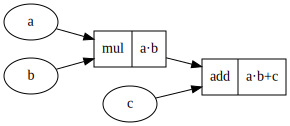

In [2]:
from graphviz import Digraph

dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add our Variables
dot.node('a'); dot.node('b'); dot.node('c')

# Add calculated values
dot.node(name='a·b', label='{mul | a·b}', shape='record')
dot.node(name='a·b+c', label='{add | a·b+c}', shape='record')

# Connect the nodes
dot.edge('a', 'a·b')
dot.edge('b', 'a·b')
dot.edge('a·b', 'a·b+c')
dot.edge('c', 'a·b+c')

# Plot the tree
dot

There are also some operations we will use that take just 1 input and produce 1 output. Here's the full list of operations we'll use as building blocks.

__2 Inputs, 1 Output__
 - Addition - $ x + y = z$

 - Multiplication - $ x * y = z$

 - Exponentiation - $ x ^ y = z$

__1 Input, 1 Output__
 - Natural Exponentiation - $ e ^ y  = z $

 - Natural Log - $ \ln(y) = z$

# Beginnings of a Neural Network - Neurons

Up until now I've purposely avoided any reference to how artificial neural networks are supposed to model the network of neurons in our brain, primarily because they don't (our brains don't use backprop).

However, to build our artificial neural network (ANN) we need to introduce the concept of a neuron, so I'll lean into the analogy a bit.

![nn](./imgs/nn.png)

In brain terms
- The leftmost neurons would be inputs from sight, sound, touch, etc. The interface between the external world and us.
- The middle "hidden" neurons would represent the neurons in our brain, gradually forming more complex and abstract rerpesentations.
- The connecting edges representing electrical signals fired by neurotransmitters between neurons.
- The rightmost neurons would be outputs, the final "thought" formed by the brain.

The use of nodes and edges also has some structural resemblance to the graph we made above - in fact, we can recreate this image like so:

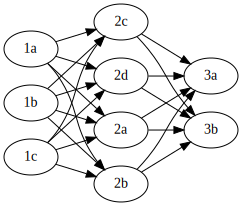

In [3]:
dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

# Add our Variables
l1 = ['1a', '1b', '1c']
dot.node('1a'); dot.node('1b'); dot.node('1c')

l2 = ['2a', '2b', '2c', '2d']
dot.node('2a'); dot.node('2b'); dot.node('2c'); dot.node('2d')

l3 = ['3a', '3b']
dot.node('3a'); dot.node('3b')

# Connect the nodes
for _in in l1:
    for _out in l2:
        dot.edge(_in, _out)
        
for _in in l2:
    for _out in l3:
        dot.edge(_in, _out)

# Plot the tree
dot

We'll dive more into neurons in future notebooks, but for now understand that a neuron is like a small "compute unit".

However, this small unit can be broken down in the way that we broke our function down until it could be expressed as binary operations between two values, which we'll call...

# Scalars

This is going to be the meat of this notebook and the basic building block of KaiTorch.

These scalar values will essentially be what would happen if we "exploded" each neuron into basic binary operations.

- Addition

- Multiplication
    
- Exponentiation

- etc.

Eventually, we'll assemble these scalars into a Directed Acyclic Graph which can built to represent neurons, layers, and finally a complete neural network. 

### __Directed Acyclic Graphs__ 
Directed Acyclic Graphs (DAGS) are graphs built by connecting nodes (our Scalars) with directed edges, with the property that there are no cycles formed - meaning that the a node's output will never be used in the calculation of its input. The DAG can be considered as the computational graph of a function.

For now though, lets focus on building our Scalar class. Each scalar will need to store:
- `data` - the value of the scalar
- `_prev` - the inputs used to calculate the value
- `_op` - the operation used to compute the value

In [4]:
import math 

class Scalar:

    def __init__(self, data, _in=(), _op=''):

        self.data = data
        self._prev = set(_in)
        self._op = _op

Let's also add a repr function, which defines the print representation of our Scalar object.

_Note: I'm adding methods to the class in a way that I wouldn't recommend, I'm doing it this way to break up long blocks of code. Feel free to reference the GitHub repo for the full code, or piece these together yourself if you'd like._

In [5]:
print(f'Without __repr__(): {Scalar(5)}')

def __repr__(self):
    return f'Scalar(data={self.data})'

Scalar.__repr__ = __repr__ 

print(f'With __repr__():    {Scalar(5)}')

Without __repr__(): <__main__.Scalar object at 0x7f8d29721be0>
With __repr__():    Scalar(data=5)


We will also need to define our base operations:
- Addition
- Multiplication
- Exponentiation
- Natural Exponentiation
- Natural Log

__Note 1:__ Since the `Scalar` class will be our building block, we want to make sure that any calculation between variable values are converted to this class to ensure we can build our graph. We use `isinstance()` for type checking and perform type conversion in the beginning if necessary.

__Note 2:__ You'll notice that the result of every operation isn't a number, but an instance of a Scalar, where we store the result of the calculation, the inputs to the calculation, and the operation used.

__Note 3:__ The reason we define the calculation in `_forward()` is because this is used for the forward pass (calculating the output) of our neural network. Eventually, we will also need a `_backward()` counterpart for the backward pass (calculating the gradients) of the neural network.

In [6]:
# Addition

def __add__(a, b):

    a = a if isinstance(a, Scalar) else Scalar(a)
    b = b if isinstance(b, Scalar) else Scalar(b)

    # Calculation: y = a + b

    def _forward():
        _a = a.data
        _b = b.data
        _y = _a + _b
        return Scalar(_y, _in=(a, b), _op='+')

    y = _forward()

    return y

Scalar.__add__ = __add__

In [7]:
# Multiplication

def __mul__(a, b):

    a = a if isinstance(a, Scalar) else Scalar(a)
    b = b if isinstance(b, Scalar) else Scalar(b)

    # Calculation: y = a * b

    def _forward():
        _a = a.data
        _b = b.data
        _y = _a * _b
        return Scalar(_y, _in=(a, b), _op='*')
    y = _forward()

    return y

Scalar.__mul__ = __mul__

In [8]:
# Exponentiation

def __pow__(a, b):

    assert isinstance(b, (int, float)), "Exponent is not int/float"

    # Calculation: y = a ** b

    def _forward():
        _a = a.data
        _y = (_a + 1e-8) ** b  # don't divide by 0 kids :)
        return Scalar(_y, _in=(a,), _op=f'**{b}')
    y = _forward()

    return y

Scalar.__pow__ = __pow__

In [9]:
# Natural Exponentiation

def exp(a):

    # Calculation: y = e ** a

    def _forward():
        _a = a.data
        _y = math.exp(_a)
        return Scalar(_y, _in=(a, ), _op='exp')
    y = _forward()

    return y

Scalar.exp = exp

In [10]:
# Natural Log - we add a small epsilon `1e-8` because log(0) is undefined and we want to avoid this.

def log(a):

    # Calculation: y = ln(a)

    def _forward():
        _a = a.data
        _y = math.log(_a + 1e-8)

        return Scalar(_y, _in=(a, ), _op='ln')
    y = _forward()

    return y

Scalar.log = log

__Done__ - you might be wondering why our binary operators are defined with these "double under" function names, such as `__add__()`

There are a certain set of python function names that are considered __magic methods__ and allow __operator overload__, essentially allowing us to define the way certain symbols (such as +, -, /, \*) work for our class. Here are the ones we will use:

- `__add__(a, b)` -> `a + b`

- `__mul__(a, b)` -> `a * b`

- `__pow__(a, b)` -> `a ** b`

- A few more that will be introduced as we go

Just to make a point, if we don't add these to our Scalar class this is what happens.

In [11]:
class WrongScalar:
    
    def __init__(self, data, _in=(), _op=''):

        self.data = data
        self._prev = set(_in)
        self._op = _op

WrongScalar(1) + WrongScalar(2)

TypeError: unsupported operand type(s) for +: 'WrongScalar' and 'WrongScalar'

__Here is our scalar class in action__

In [12]:
Scalar(1) + Scalar(2)

Scalar(data=3)

In [13]:
Scalar(3) * Scalar(2)

Scalar(data=6)

In [14]:
Scalar(3) ** 0

Scalar(data=1.0)

__What if we try to interact with non-Scalar values?__

In [15]:
Scalar(1) + 2

Scalar(data=3)

In [16]:
Scalar(3) * 2

Scalar(data=6)

In [17]:
1 + Scalar(2)

TypeError: unsupported operand type(s) for +: 'int' and 'Scalar'

In [18]:
3 * Scalar(2)

TypeError: unsupported operand type(s) for *: 'int' and 'Scalar'

__?_?__

This error occurs because when we add or multiply two objects, the method of the left-hand class is used - when we perform `Scalar(1) + 2`, we are using Scalar addition which has built in type conversion that converts the value on the right to a Scalar

When we perform `1 + Scalar(2)`, we are using integer addition, which cannot handle our Scalar class.

Luckily, we also have the `__radd__, __rmul__` magic methods - which will use method of the right class if the method of the left class cannot be used.

In [19]:
def __radd__(a, b):

    # b + a = a + b
    return a.__add__(b)

Scalar.__radd__ = __radd__

In [20]:
def __rmul__(a, b):

    # b * a = a * b
    return a.__mul__(b)

Scalar.__rmul__ = __rmul__

and now it works :)

In [21]:
1 + Scalar(2)

Scalar(data=3)

In [22]:
3 * Scalar(2)

Scalar(data=6)

__What about subtraction, division, and negatives?__

We'll add these in too, but these functions can all be expressed as a combination of the methods we've already defined. Technically, these aren't necessities.
- `__neg__(a)` -> `-a`
- `__sub__(a, b)` -> `a - b`
- `__truediv__(a, b)` -> `a / b`

In [23]:
def __neg__(a):

    # -a = a * -1
    return a.__mul__(-1)

Scalar.__neg__ = __neg__

In [24]:
def __sub__(a, b):

    # a - b = a + (b * -1)
    return a.__add__(b.__neg__())

def __rsub__(a, b):

    # b - a = (a * -1) + b
    return (a.__neg__()).__add__(b)

Scalar.__sub__ = __sub__
Scalar.__rsub__ = __rsub__

In [25]:
def __truediv__(a, b):

    # a / b = a * (b ** -1)
    return a.__mul__((b + 1e-8).__pow__(-1)) # Avoid Division by 0

def __rtruediv__(a, b):

    # b / a = b * (a ** -1)
    return Scalar(b).__mul__((a + 1e-8).__pow__(-1)) # Avoid Division by 0

Scalar.__truediv__ = __truediv__
Scalar.__rtruediv__ = __rtruediv__

__Testing them out__

In [26]:
-Scalar(3)

Scalar(data=-3)

In [27]:
1 - Scalar(-1)

Scalar(data=2)

In [28]:
Scalar(5) - 6

Scalar(data=-1)

In [29]:
Scalar(21) / 3

Scalar(data=6.9999999766666665)

In [30]:
20 / Scalar(5)

Scalar(data=3.999999984)

__And we're done! ✌️__ - these are all the operators we will use in KaiTorch.

Now, by chaining `Scalars` together with operations, we can build out more complex and expressive functions.

# Chaining Scalars

Recall our very first function in Notebook 0
$$f(x) = 2x^2 - 3x + 4$$

Let's recreate this using our new Scalar class, setting $x=3$

In [31]:
x = Scalar(3)
2*x**2 - 3*x + 4

Scalar(data=13.00000012)

In [32]:
x = 3
2*x**2 - 3*x + 4

13

What about our simple multi-variate function?
$$f(a, b, c) = a * b + c$$

In [33]:
a = Scalar(5); a.label = 'a'
b = Scalar(3); b.label = 'b'
c = Scalar(-6); c.label = 'c'

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
e

Scalar(data=9)

Let's inspect our calculated `Scalars`

In [34]:
def inspect(s):
    print(f'The value of {s.label} is {s.data}')
    print(f'Inputs used:')
    for i in s._prev:
        print(f' - {i.label}: {i.data}')
    print(f'Operation used: {s._op}')

In [35]:
inspect(d)

The value of d is 15
Inputs used:
 - a: 5
 - b: 3
Operation used: *


In [36]:
inspect(e)

The value of e is 9
Inputs used:
 - c: -6
 - d: 15
Operation used: +


__Nice, everything is connected!__

All that's left is write a function to dynmaically build our function starting from the output, and working backwards until we have a DAG representation of the function.

# Recursively Generating a DAG

If you're not familiar with recursion, it's basically when a function that contains a set of instructions, which includes calling itself at some point, is run until it no longer needs to call itself.

In `trace(root)`, we're initializing sets `nodes` and `edges` to build our graph.

In `build(node)`, we:
- Add the parent `node` to `nodes`
- For each child in `node._prev`:
    - Add the directed edge `(child, node)` to `edges`
    - Call `build(child)`
    
___[note for those who are coding along]___

When `# kaitorch/___.py` is included in a cell, it contains code that is used in the final version of KaiTorch :) You can use this to build your own modules.

In [37]:
# kaitorch/graph.py

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [38]:
nodes, edges = trace(e)
print(f'Nodes: {nodes}')
print(f'Edges: {edges}')

Nodes: {Scalar(data=3), Scalar(data=15), Scalar(data=-6), Scalar(data=9), Scalar(data=5)}
Edges: {(Scalar(data=-6), Scalar(data=9)), (Scalar(data=15), Scalar(data=9)), (Scalar(data=5), Scalar(data=15)), (Scalar(data=3), Scalar(data=15))}


__This is all the information we need to build our function as a DAG, let's try it out.__

In [39]:
def plot_model(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # L to R

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        
        # For every Scalar object, create a node
        dot.node(name=uid, label="{data %.4f}"%(n.data), shape='record')
        
        # If a Scalar is a calculated value (not an input)
        if n._op:
            
            # Create a node representing the operation
            dot.node(name=uid+n._op, label=n._op)
            
            # Draw an edge from the operation to the Scalar
            dot.edge(uid+n._op, uid)

    # For every input to output edge
    for n1, n2 in edges:
        
        # Draw an edge from the input to the operator used to calculate the output
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

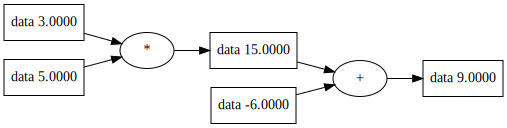

In [40]:
plot_model(e)

__🥳 We've successfully represented the function `a + b * c` as a__ _(very very simple)_ __feed forward neural net!__ _(All FFNNs are DAGs)_

I highly encourage you to use this notebook to build out some more complex functions and check out the DAGs produced.

# Looking Ahead

As a little taste of what's to come, the computation we've performed above is actually the computation of a single, unactivated neuron, with one input.

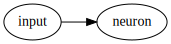

In [41]:
dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

dot.node('input'); dot.node('neuron')
dot.edge('input', 'neuron')

dot

Here's what each variable would represent:

- `a` - Input variable `in`
- `b` - The weight of node `out` that is associated with input `in`
- `c` - The bias of node `out`

The output of each dense node is the dot product of its inputs and weights, with a bias term added. We'll go deeper into this when we code our Dense layer!

__We're done here, but ending with a tiny rant__

I hate it when I'm going throgh a tutorial and the code don't match the repo, and you have to go back and forth between the tutorial, your own code, and the repo trying to find the missing pieces, so I'll try to avoid doing that.

You'll notice the above `plot_model()` function is slightly different from the one in the repo, which is:

In [42]:
# kaitorch/graph.py

def plot_model(root, filename=None):
    dot = Digraph(format='png', graph_attr={'rankdir': 'TB'})

    all_nodes = set()
    all_edges = set()
    
    if not isinstance(root, list):
        root = [root]

    for r in root:
        nodes, edges = trace(r)
        all_nodes = all_nodes.union(nodes)
        all_edges = all_edges.union(edges)
    all_nodes = list(all_nodes)
    all_edges = list(all_edges)

    for n in all_nodes:
        uid = str(id(n))

        dot.node(name=uid,
                 label="{data %.4f | grad %.4f}" % (n.data, n.grad),
                 shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in all_edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    if filename:
        dot.render(filename=filename, view=True)
    return dot

This is a slight modification of what Andrej Karpathy used in his micrograd tutorial - this is because we eventually implement Multi-class Classification which has multiple output nodes, meaning this function has to handle the case where we have multiple root nodes.

Functionally, it works the same for single output networks.

We also add the option to render to a file because as you'll soon see, these networks very quickly become too large to properly view in a small notebook window. The graph will be rendered to a .png if you provide a filename.

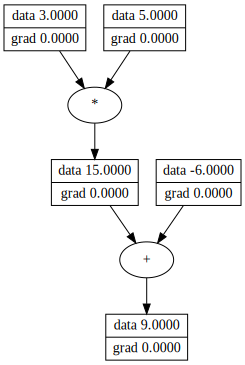

In [43]:
Scalar.grad = 0 # I'll explain this in a later notebook

plot_model(e, filename='imgs/example')

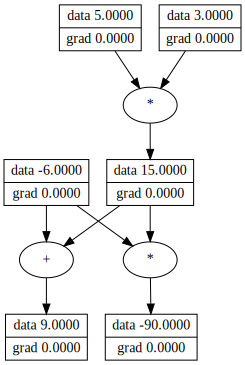

In [44]:
a = Scalar(5); a.label = 'a'
b = Scalar(3); b.label = 'b'
c = Scalar(-6); c.label = 'c'

d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = d * c; f.label = 'f'

plot_model([e, f])